In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

In [180]:
data = pd.read_csv('Downloads/Jumpman23/analyze_me.csv')

Agenda:

1. Data Integrity
2. Look for popular categories - can target
3. Identify speed of vehicicles - identify inefficiencies 
4. Length to order - correlated to specific place?
5. Location - look for clustering

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   delivery_id                          5983 non-null   int64  
 1   customer_id                          5983 non-null   int64  
 2   jumpman_id                           5983 non-null   int64  
 3   vehicle_type                         5983 non-null   object 
 4   pickup_place                         5983 non-null   object 
 5   place_category                       5100 non-null   object 
 6   item_name                            4753 non-null   object 
 7   item_quantity                        4753 non-null   float64
 8   item_category_name                   4753 non-null   object 
 9   how_long_it_took_to_order            3038 non-null   object 
 10  pickup_lat                           5983 non-null   float64
 11  pickup_lon                    

In [192]:
#converting time columns to datetime
time_categories = ['when_the_delivery_started','when_the_Jumpman_arrived_at_pickup','when_the_Jumpman_left_pickup','when_the_Jumpman_arrived_at_dropoff']
for cat in time_categories:
    data.loc[:,cat] = data[cat].apply(lambda x: pd.to_datetime(x))

In [281]:
print("Earliest Timetamp: %s" %min([min(data[x].dropna()) for x in time_categories]))
print("Latest Timestamp: %s"%max([max(data[x].dropna()) for x in time_categories]))
      
      

Earliest Timetamp: 2014-10-01 00:07:58.632482
Latest Timestamp: 2014-10-30 23:29:44.866438


In [13]:
#Day of the month - all data is in October
data.loc[:,'day'] = data['when_the_delivery_started'].apply(lambda x: x.day)

# Data Integrity Analysis

In [9]:
for c in data.columns:
    if data.loc[:,c].isna().sum() > 0:
        print("%.02f%% of data is missing for %s"%(data.loc[:,c].isna().sum()/len(data)*100,c.replace("_",' ').title()))

14.76% of data is missing for Place Category
20.56% of data is missing for Item Name
20.56% of data is missing for Item Quantity
20.56% of data is missing for Item Category Name
49.22% of data is missing for How Long It Took To Order
9.19% of data is missing for When The Jumpman Arrived At Pickup
9.19% of data is missing for When The Jumpman Left Pickup


## We can immediatley see there is some missing data. This can be aggregated into 4 categories:

1. 49.22% of the data is missing for how long it took to order
2. 20.56% of the data is missing for item information
3. 14.76% of the data is missing for place category
4. 9.19% of data is missing for pickup time

## We will come back to this after exploring duplicates

In [14]:
duplicates = data.duplicated(keep=False)
dup_index = duplicates[duplicates].index
duplicates_df = data.iloc[dup_index,:]
print(duplicates_df.delivery_id.value_counts())
print("\n",len(duplicates_df.delivery_id.unique()))

1341790    2
1396918    2
1343449    2
1280728    2
1423447    2
1428278    2
1487890    2
1474704    2
1363244    2
1319722    2
1274791    2
1349702    2
1279990    2
1344900    2
1282262    2
1491424    2
Name: delivery_id, dtype: int64

 16


## 16 rows are duplicated throughout the dataset. The current dataset doesn't provide enough information to determine if these are actual duplicates or not. It is possible the item aggregation is failing (ex. showing 2 rows of  1 quantity instead of 1 row with 2 quantity). It is also possible they are actual duplicates due to a system error

In [15]:
#If this returned nothing it could reinforce item_quantity not aggregating properly. Still a possibility.
duplicates_df.loc[duplicates_df.item_quantity>1,:]

delivery_id  customer_id  jumpman_id vehicle_type  pickup_place  \
2341      1349702        42781       65763      bicycle  2nd Ave Deli   
3070      1349702        42781       65763      bicycle  2nd Ave Deli   

     place_category     item_name  item_quantity  item_category_name  \
2341           Deli  Potato Knish            2.0  Franks and Knishes   
3070           Deli  Potato Knish            2.0  Franks and Knishes   

     how_long_it_took_to_order  pickup_lat  pickup_lon  dropoff_lat  \
2341           00:06:54.394431   40.745299  -73.979138    40.738913   
3070           00:06:54.394431   40.745299  -73.979138    40.738913   

      dropoff_lon  when_the_delivery_started  \
2341    -73.98776 2014-10-12 19:52:26.821498   
3070    -73.98776 2014-10-12 19:52:26.821498   

     when_the_Jumpman_arrived_at_pickup when_the_Jumpman_left_pickup  \
2341         2014-10-12 20:21:08.326255   2014-10-12 20:40:57.055153   
3070         2014-10-12 20:21:08.326255   2014-10-12 20:40:57.055153   

     when_the_Jumpman_arrived_at_dropoff  day  
2341          2014-10-12 20:49:50.794829   12  
3070          2014-10-12 20:49:50.794829   12

In [365]:
data.delivery_id.value_counts()

1460296    5
1286826    4
1319971    4
1475127    4
1343610    4
          ..
1399676    1
1432665    1
1363103    1
1356960    1
1327104    1
Name: delivery_id, Length: 5214, dtype: int64

In [16]:
#For any analysis not pertaining to items we need to make sure that a delivery isn't being counted multiple times.
data2 = data.copy()
data2.drop(['item_name','item_quantity','item_category_name'],axis=1,inplace=True)
data2.drop_duplicates(inplace=True)

## Place Category Missing Data Exploration

In [17]:
na_check = data2.loc[data2.place_category.isna(),:].pickup_place.value_counts().keys()
na_check

Index(['Momofuku Noodle Bar', 'La Esquina Taqueria', 'Katz's Delicatessen',
       '$10 Blue Ribbon Fried Chicken Sandwich', 'The Mercer Kitchen',
       'Pommes Frites', 'Crif Dogs', 'Habana To Go', 'CVS Pharmacy',
       'Clinton St. Baking Co. & Restaurant',
       ...
       'Outback Steakhouse', 'Perelandra Natural Foods', '158',
       'Milano Market', '29 w 57th st', 'Tevere 84', 'Nikko',
       'Lady M Cake Boutique', 'Hester Street Fair', 'New London Pharmacy'],
      dtype='object', length=419)

In [18]:
#419 places are missing category
#We can search through the places and see if the category name appears elsewhere to replace
for rest in na_check:
    num = len(data2.loc[(data2.pickup_place == rest)&(~data2.place_category.isna()),:])
    if num >0:
        replace_with = data2.loc[data2.pickup_place == rest,:].place_category.value_counts().keys()[0]
        print("%s missing %i - replace with %s"%(rest,num,replace_with))

Dunkin Donuts missing 4 - replace with Fast Food
Barnes & Noble missing 1 - replace with Book Store
Burger Joint missing 16 - replace with Burger
Insomnia Cookies missing 10 - replace with Bakery
Antique Garage missing 1 - replace with Italian
Staples missing 5 - replace with Office Supplies Store
Joe's Pizza missing 17 - replace with Pizza
Sushi Seki (archived) missing 18 - replace with Japanese
The Container Store missing 2 - replace with Specialty Store
Num Pang Sandwich Shop missing 8 - replace with Asian
Panera Bread missing 1 - replace with Restaurant
Wolfgang's Steakhouse missing 1 - replace with Steak
Duane Reade duplicate missing 2 - replace with Convenience Store
Moe's Southwest Grill missing 1 - replace with Mexican


### This appears to be indicitve of a problem with the system as opposed to the place not providing the information. An immediate resolution would be to fill the missing data with the values we already have on other deliveries. For the rest of the missing data further analysis is needed

## Pickup Time Missing Data Exploration


In [19]:
latitude_max = max((data.pickup_lat.max(),data.dropoff_lat.max()))
longitude_max = max((data.pickup_lon.max(),data.dropoff_lon.max()))
latitude_min = min((data.pickup_lat.min(),data.dropoff_lat.min()))
longitude_min = min((data.pickup_lon.min(),data.dropoff_lon.min()))
BBox = ((longitude_min,longitude_max,latitude_min, latitude_max))
#map file created on https://www.openstreetmap.org/ using longitude and latitude
ny_map = plt.imread('Downloads/ny_map.png')

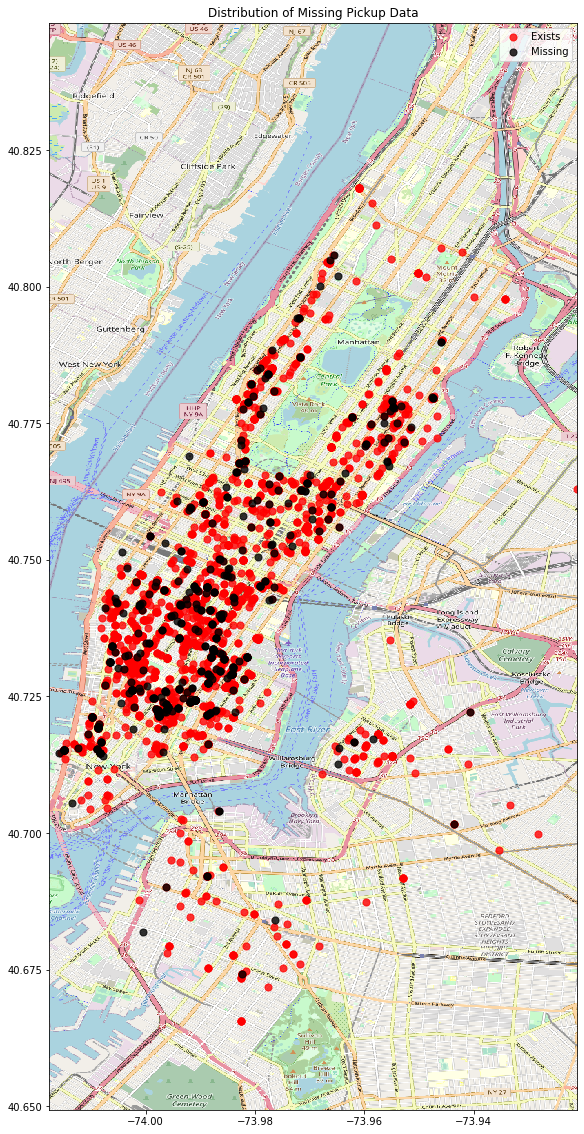

In [101]:
fig, ax = plt.subplots(figsize = (20,20))
colors = ['r','k']
labels = ['Exists','Missing']
for i,val in enumerate([False,True]):
    im = ax.scatter(data2.loc[data2.when_the_Jumpman_arrived_at_pickup.isna() == val,:].pickup_lon, data2.loc[data2.when_the_Jumpman_arrived_at_pickup.isna() == val,:].pickup_lat, alpha= .8,label=labels[i],color=colors[i], s=50)
    ax.set_title('Distribution of Missing Pickup Data')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(ny_map, extent = BBox, aspect= 'equal')
    ax.legend()

In [21]:
vehicles= data.vehicle_type.unique()

In [22]:
for vehicle in vehicles:
    print('Vehicle %s- %.02f%%'%(vehicle, data.loc[data.vehicle_type == vehicle,'when_the_Jumpman_arrived_at_pickup'].isna().sum()/len(data.loc[data.vehicle_type == vehicle,'when_the_Jumpman_arrived_at_pickup'])))
    
    

Vehicle van- 0.13%
Vehicle bicycle- 0.09%
Vehicle car- 0.08%
Vehicle walker- 0.09%
Vehicle truck- 0.12%
Vehicle scooter- 0.08%
Vehicle motorcycle- 0.05%


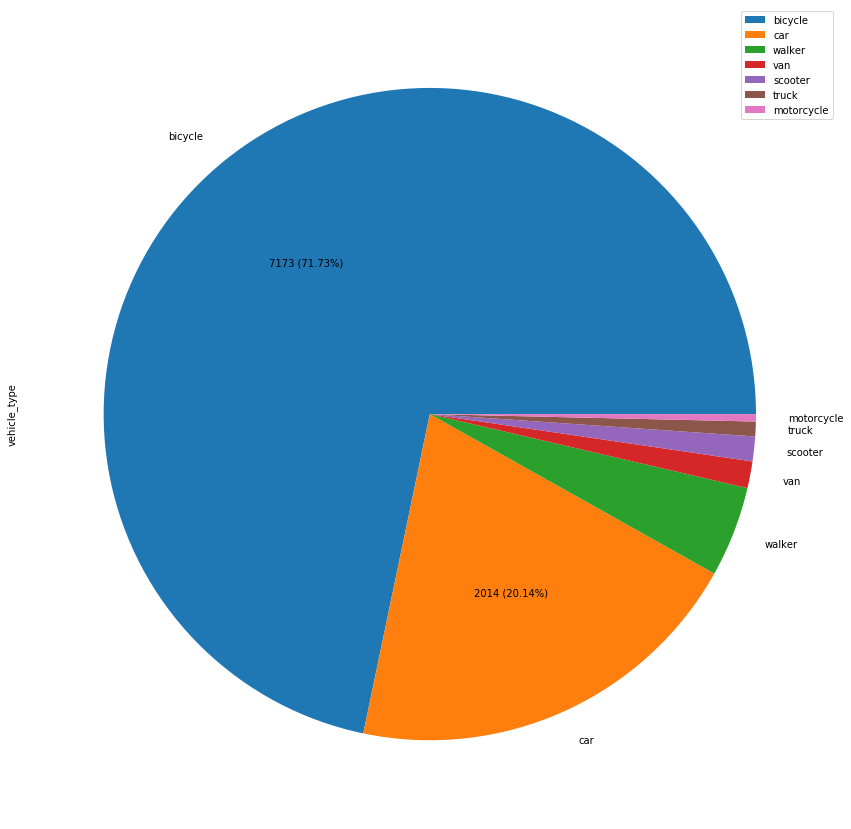

In [168]:
def my_autopct(pct):
    return '%.0f (%.2f%%)' % (pct*100,pct) if pct > 5 else ''
plt.figure(figsize=(15,15))
data2.loc[:,'vehicle_type'].value_counts().plot(kind = 'pie',autopct = my_autopct)
plt.legend()

In [23]:
data.vehicle_type.value_counts()

bicycle       4274
car           1215
walker         274
van             76
scooter         75
truck           48
motorcycle      21
Name: vehicle_type, dtype: int64

### The geographic distribution of where the pickup data is missing is similiar to the overall dataset. We can see that when looking by vehicle time there is a large range, however, due to the small sample size of most vehicle types this would need to be explored further.

## How long it took to order missing data exploration


day 1- 50.00%
day 2- 54.49%
day 3- 59.04%
day 4- 53.05%
day 5- 47.69%
day 6- 50.00%
day 7- 48.68%
day 8- 48.65%
day 9- 46.34%
day 10- 53.80%
day 11- 48.85%
day 12- 44.34%
day 13- 45.45%
day 14- 58.82%
day 15- 53.01%
day 16- 51.80%
day 17- 56.44%
day 18- 48.17%
day 19- 48.43%
day 20- 51.23%
day 21- 53.06%
day 22- 48.99%
day 23- 48.30%
day 24- 48.74%
day 25- 57.14%
day 26- 43.02%
day 27- 52.60%
day 28- 49.45%
day 29- 49.37%
day 30- 55.38%


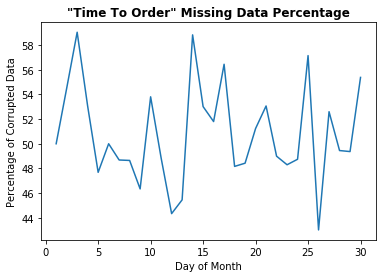

In [187]:
for d in range(1,31):
    print('day %s- %.02f%%'%(d, data2.loc[data2.day == d,'how_long_it_took_to_order'].isna().sum()*100/len(data2.loc[data2.day == d,'how_long_it_took_to_order'])))
    
def calc_perc(val):
    return val.isna().sum()/len(val)*100
day_pivot = pd.pivot_table(data=data2,index='day',values='how_long_it_took_to_order',aggfunc=calc_perc)
day_pivot.plot(legend=None)
plt.xlabel("Day of Month")
plt.ylabel("Percentage of Corrupted Data")
plt.title('"Time To Order" Missing Data Percentage',weight='bold')
plt.show()
    

### Testing to see if there was an issue that could have been affecting data gathering at a certain period in time. However, no day stands out as having an unusually large percentage of missing data

How long it took to order data integrity exploration

# Data Analysis

In [38]:
cord_cols = ['pickup_lat','pickup_lon','dropoff_lat','dropoff_lon']
for col in cord_cols:
    data2[col+'_rounded'] = data2.loc[:,col].apply(lambda x: round(x,2))
    
count_dict = {}
for i in range(data2.shape[0]):
    row = data2.iloc[i,:]
    if (row.pickup_lat_rounded,row.pickup_lon_rounded) not in count_dict:
        count_dict[(row.pickup_lat_rounded,row.pickup_lon_rounded)] = 1
    else:
        count_dict[(row.pickup_lat_rounded,row.pickup_lon_rounded)] += 1
c_df = pd.DataFrame([{'lat':k[0],'long':k[1],'count':v} for k,v in count_dict.items()])

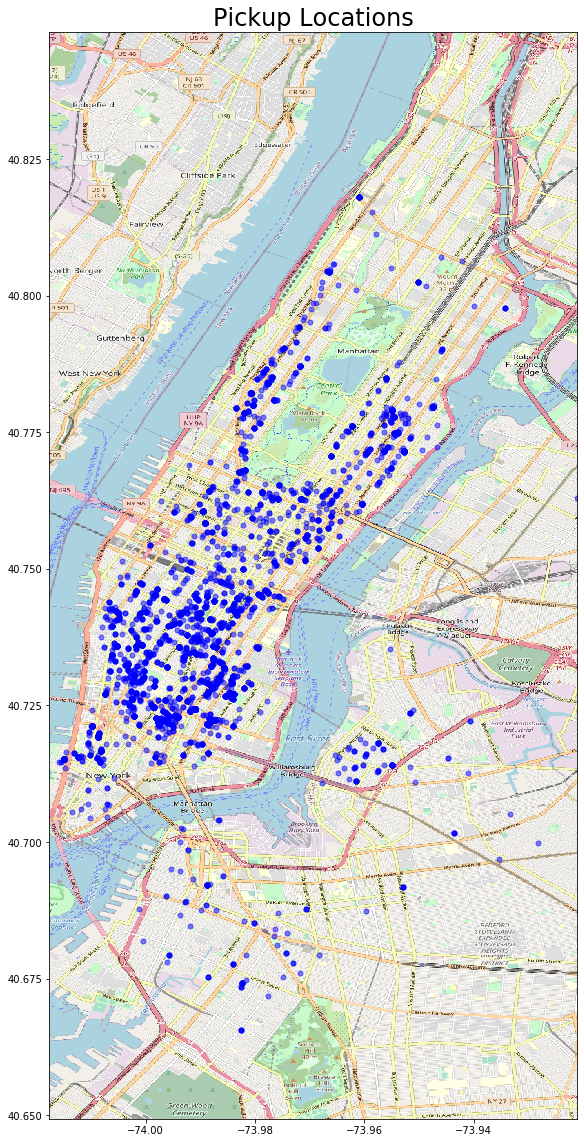

In [183]:
fig, ax = plt.subplots(figsize = (20,20))
im = ax.scatter(data2.pickup_lon, data2.pickup_lat, zorder=1, alpha= 0.5, c='b',s=25)
ax.set_title('Pickup Locations',fontsize=24)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ny_map, zorder=0, extent = BBox, aspect= 'equal')

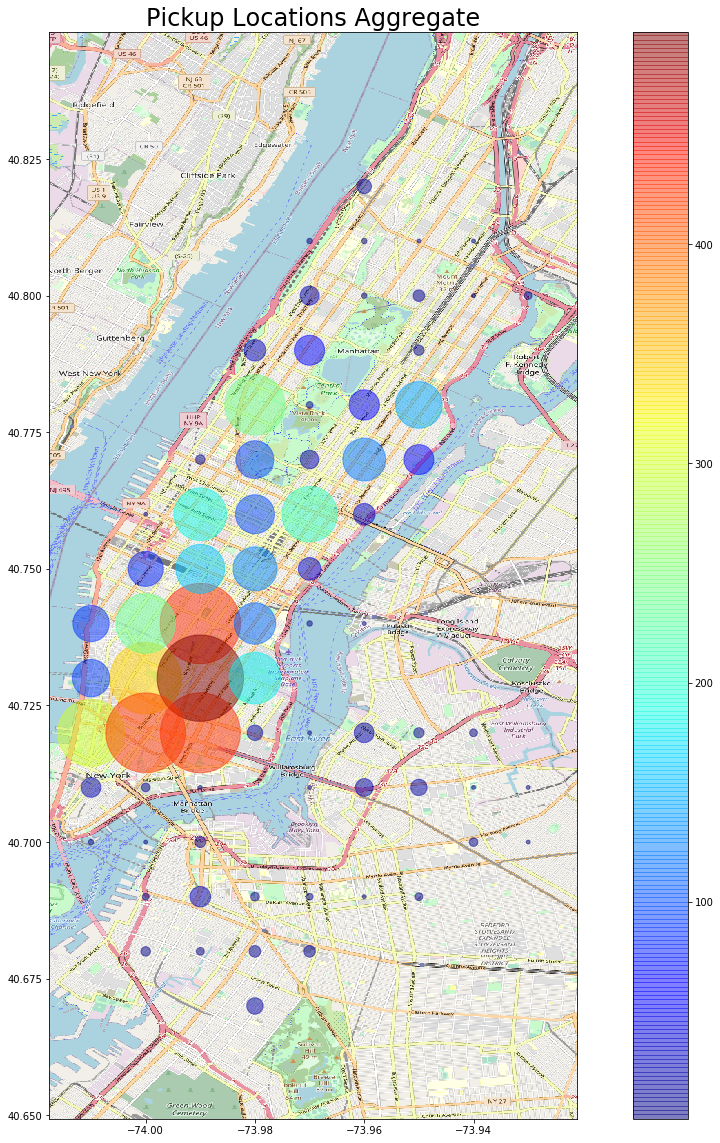

In [133]:
fig, ax = plt.subplots(figsize = (20,20))
im = ax.scatter(c_df.long, c_df.lat, zorder=1, alpha= 0.5, c=c_df['count'], cmap='jet',s=15*c_df['count'])
ax.set_title('Pickup Locations Aggregate',fontsize=24)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ny_map, zorder=0, extent = BBox, aspect= 'equal')
fig.colorbar(im)

In [40]:
count_dict2 = {}
for i in range(data2.shape[0]):
    row = data2.iloc[i,:]
    if (row.dropoff_lat_rounded,row.dropoff_lon_rounded) not in count_dict2:
        count_dict2[(row.dropoff_lat_rounded,row.dropoff_lon_rounded)] = 1
    else:
        count_dict2[(row.dropoff_lat_rounded,row.dropoff_lon_rounded)] += 1
c_df2 = pd.DataFrame([{'lat':k[0],'long':k[1],'count':v} for k,v in count_dict2.items()])

In [50]:
data2.vehicle_type.unique()

array(['van', 'bicycle', 'car', 'walker', 'truck', 'scooter',
       'motorcycle'], dtype=object)

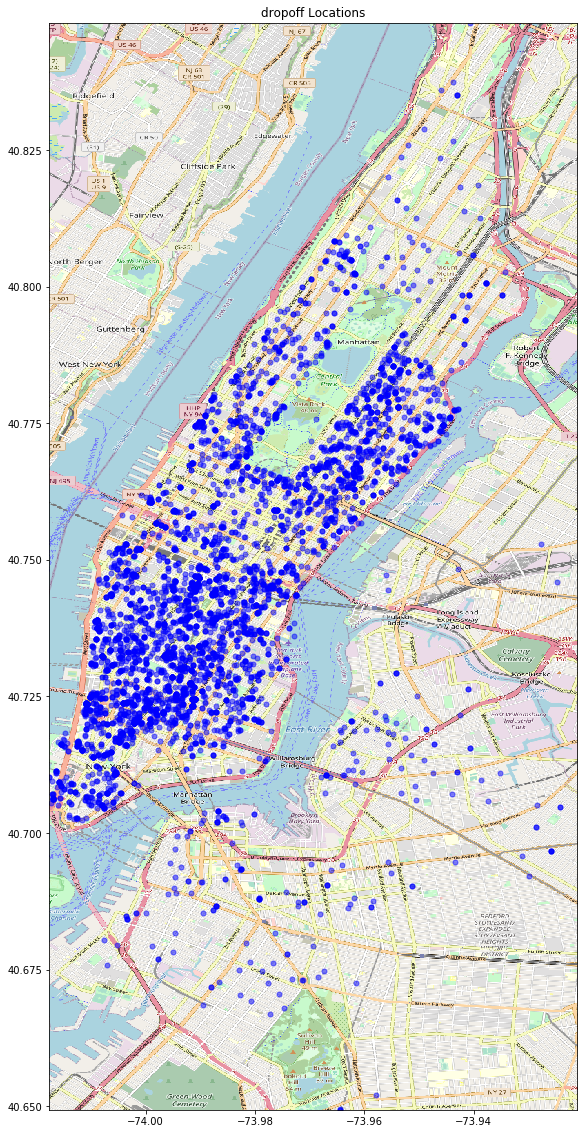

In [123]:
fig, ax = plt.subplots(figsize = (20,20))
im = ax.scatter(data2.dropoff_lon, data2.dropoff_lat, zorder=1, alpha= 0.5, c='b',s=25)
ax.set_title('Dropoff Locations',fontsize=24)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ny_map, zorder=0, extent = BBox, aspect= 'equal')

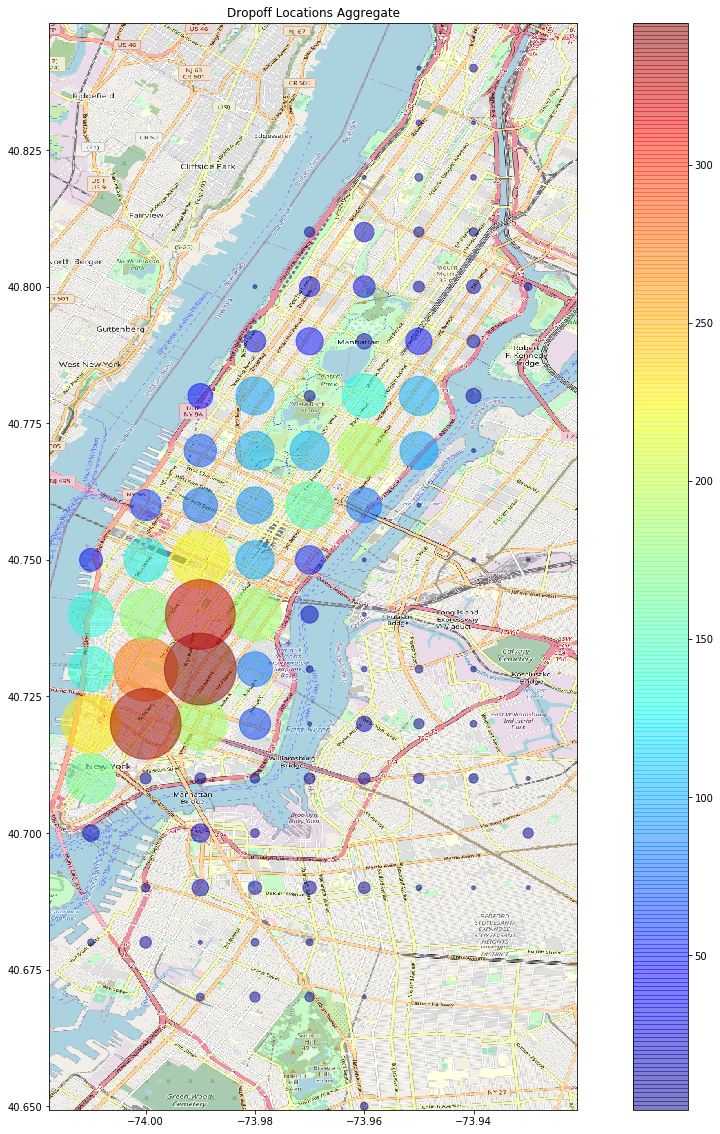

In [124]:
fig, ax = plt.subplots(figsize = (20,20))
im = ax.scatter(c_df2.long, c_df2.lat, zorder=1, alpha= 0.5, c=c_df2['count'], cmap='jet',s=15*c_df2['count'])
ax.set_title('Dropoff Locations Aggregate',fontsize=24)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ny_map, zorder=0, extent = BBox, aspect= 'equal')
fig.colorbar(im)

In [145]:
data2.place_category.unique()

array(['American', 'Pizza', 'Burger', 'Juice Bar', 'Japanese', 'Indian',
       'Sushi', 'Bakery', nan, 'Mexican', 'BBQ', 'Dessert', 'Vegan',
       'Fast Food', 'Korean', 'Drug Store', 'Italian', 'Grocery Store',
       'Breakfast', 'Coffee', 'Salad', 'Middle Eastern', 'Mediterranean',
       'Seafood', 'Russian', 'Southern', 'Vegetarian', 'Deli',
       'South American', 'French', 'Chinese', 'Asian', 'Donut',
       'Gluten-Free', 'Office Supplies Store', 'Convenience Store',
       'Shop', 'Food Truck', 'Clothing', 'German', 'Promo',
       'Electronics Store', 'Steak', 'Ice Cream', 'Thai', 'Spanish',
       'Caribbean', 'Vietnamese', 'Book Store', 'Specialty Store',
       'Eastern European', 'Kids & Baby', 'Department Store',
       'Beauty Supply', 'African', 'Restaurant', 'Art Store',
       'Pet Supplies Store'], dtype=object)

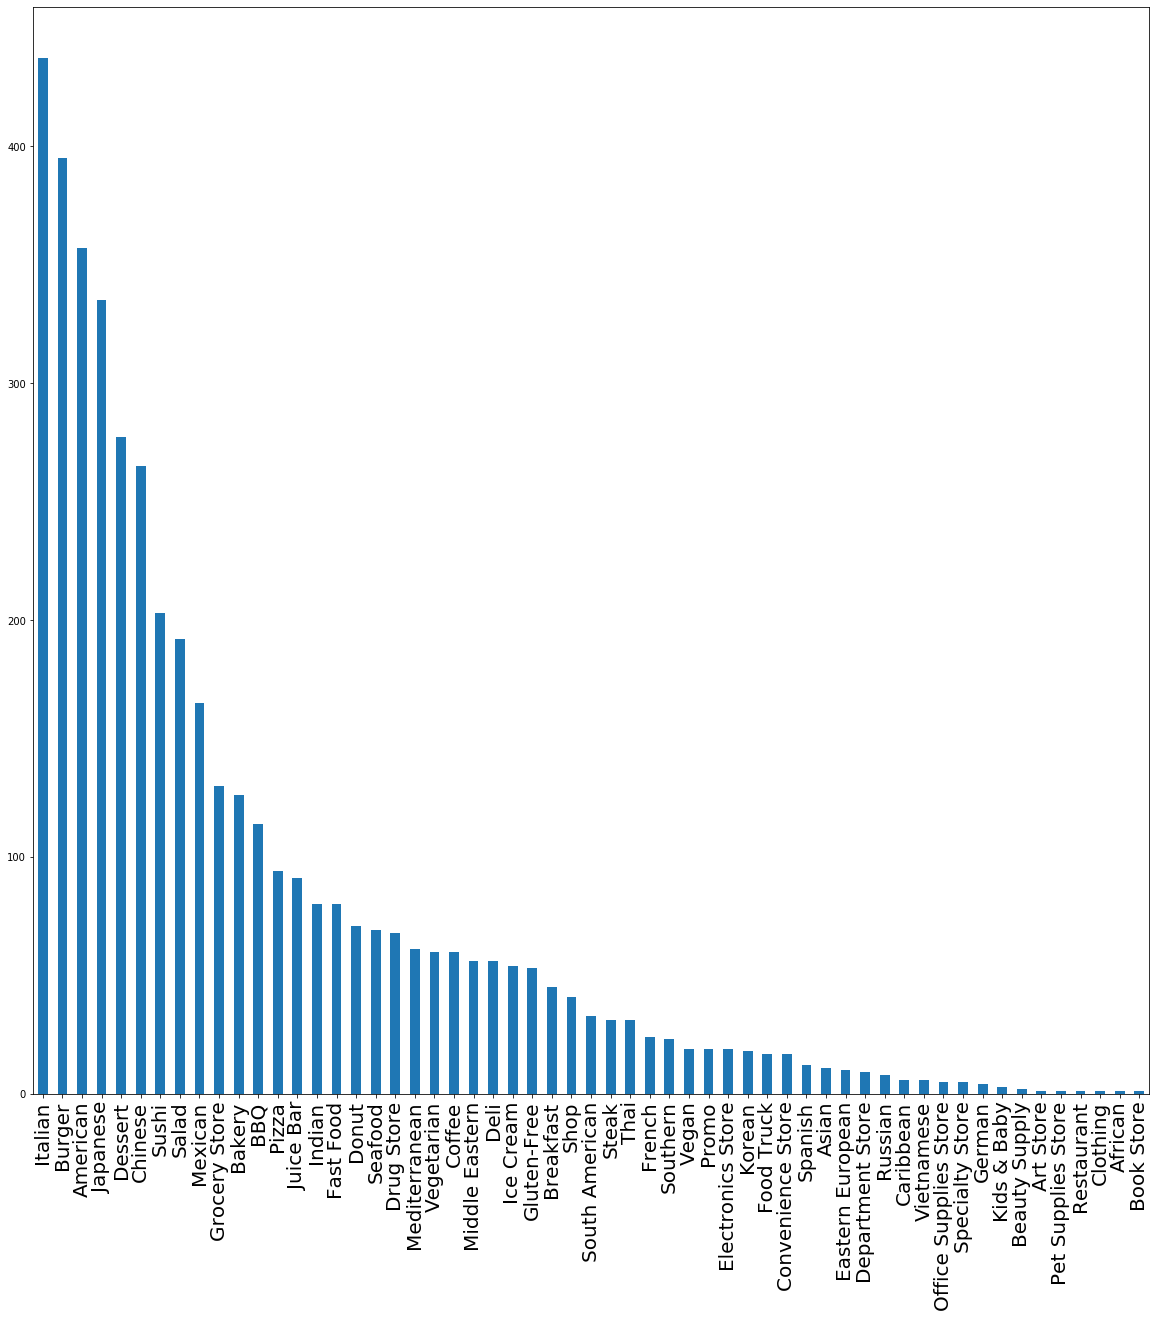

In [176]:
plt.figure(figsize=(20,20))
data2.loc[:,'place_category'].value_counts().plot(kind = 'bar')
plt.xticks(fontsize=20)
plt.show()

In [255]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5214 entries, 0 to 5981
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   delivery_id                          5214 non-null   int64         
 1   customer_id                          5214 non-null   int64         
 2   jumpman_id                           5214 non-null   int64         
 3   vehicle_type                         5214 non-null   object        
 4   pickup_place                         5214 non-null   object        
 5   place_category                       4373 non-null   object        
 6   how_long_it_took_to_order            2579 non-null   object        
 7   pickup_lat                           5214 non-null   float64       
 8   pickup_lon                           5214 non-null   float64       
 9   dropoff_lat                          5214 non-null   float64       
 10  dropoff_lon 

In [256]:
data2.loc[:,'total_time'] = (data2.loc[:,'when_the_Jumpman_arrived_at_dropoff'] - data2.loc[:,'when_the_delivery_started']).apply(lambda x : x.total_seconds()/60)
data2.loc[:,'pickup_arrival_time'] = (data2.loc[:,'when_the_Jumpman_arrived_at_pickup'] - data2.loc[:,'when_the_delivery_started']).apply(lambda x : x.total_seconds()/60)
data2.loc[:,'pickup_leave_time'] = (data2.loc[:,'when_the_Jumpman_left_pickup'] - data2.loc[:,'when_the_Jumpman_arrived_at_pickup']).apply(lambda x : x.total_seconds()/60)
data2.loc[:,'dropoff_time'] = (data2.loc[:,'when_the_Jumpman_arrived_at_dropoff'] - data2.loc[:,'when_the_Jumpman_left_pickup']).apply(lambda x : x.total_seconds()/60)





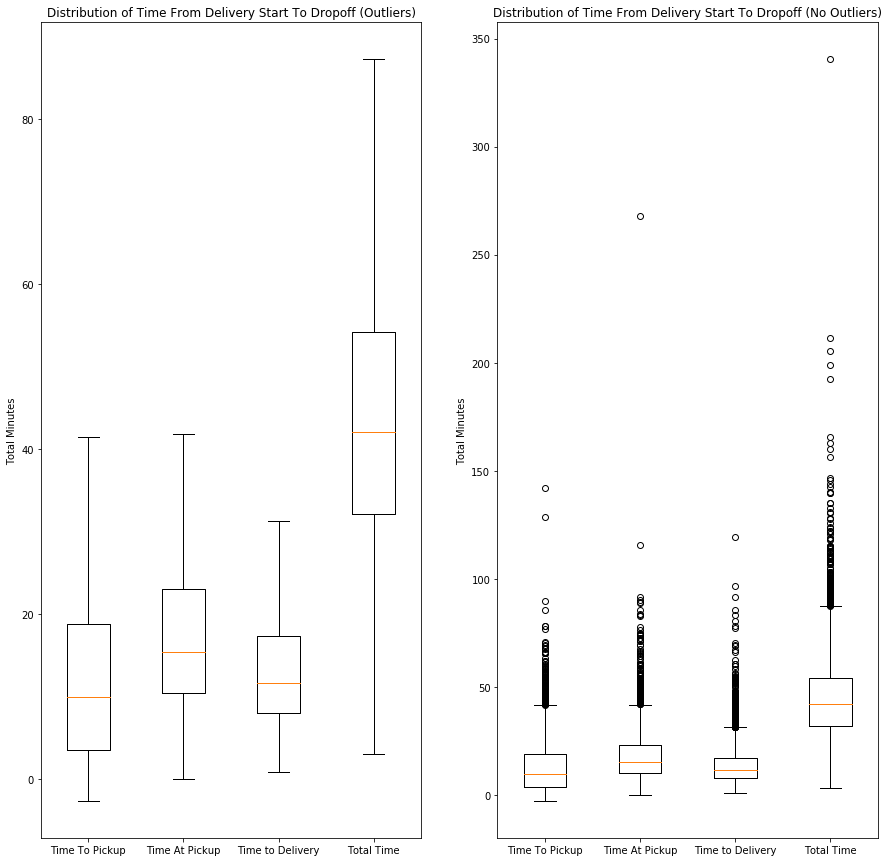

In [271]:
boxes = [data2.pickup_arrival_time.dropna(),data2.pickup_leave_time.dropna(),data2.dropoff_time.dropna(),data2.total_time.dropna()]
plt.figure(figsize=(15,15))
ax = plt.subplot(1,2,1)
ax.boxplot(boxes,showfliers=False)
plt.title("Distribution of Time From Delivery Start To Dropoff (Outliers)")
plt.ylabel("Total Minutes")
plt.xticks(range(1,5),["Time To Pickup",'Time At Pickup','Time to Delivery','Total Time'])
ax2 = plt.subplot(1,2,2)
ax2.boxplot(boxes,showfliers=True)
plt.title("Distribution of Time From Delivery Start To Dropoff (No Outliers)")
plt.ylabel("Total Minutes")
plt.xticks(range(1,5),["Time To Pickup",'Time At Pickup','Time to Delivery','Total Time'])
plt.show()

numpy.timedelta64(3606414164000,'ns')

In [ ]:
na_check = data.loc[data.place_category.isna(),:].pickup_place.value_counts().keys()

In [259]:
data['when_the_delivery_started'][0]
pd.to_datetime('2014-10-26 13:51:59.898924').month

10

In [249]:
#Exploring place category
na_check = data.loc[data.place_category.isna(),:].pickup_place.value_counts().keys()
na_check

Index(['Momofuku Noodle Bar', 'La Esquina Taqueria', 'Katz's Delicatessen',
       '$10 Blue Ribbon Fried Chicken Sandwich', 'The Mercer Kitchen',
       'Crif Dogs', 'Pommes Frites', 'Habana To Go',
       'Clinton St. Baking Co. & Restaurant', 'Citarella',
       ...
       'Grano Trattoria', 'Two Boots', 'Lili's Noodle Shop & Grill', 'BeQu',
       'Risotteria Melotti', 'Gyu-Kaku East Village', 'Periyali',
       'The Tumi Store', 'Bread', 'Dough'],
      dtype='object', length=419)

In [253]:
#419 places are missing category
#We can search through the places and see if the category name appears elsewhere to replace
for rest in na_check:
    num = len(data.loc[(data.pickup_place == rest)&(~data.place_category.isna()),:])
    if num >0:
        replace_with = data.loc[data.pickup_place == rest,:].place_category.value_counts().keys()[0]
        print("%s missing %i - replace with %s"%(rest,num,replace_with))

Dunkin Donuts missing 4 - replace with Fast Food
Barnes & Noble missing 1 - replace with Book Store
Burger Joint missing 16 - replace with Burger
Antique Garage missing 1 - replace with Italian
Insomnia Cookies missing 12 - replace with Bakery
Staples missing 5 - replace with Office Supplies Store
Moe's Southwest Grill missing 1 - replace with Mexican
Duane Reade duplicate missing 2 - replace with Convenience Store
Sushi Seki (archived) missing 18 - replace with Japanese
Panera Bread missing 1 - replace with Restaurant
Joe's Pizza missing 18 - replace with Pizza
Wolfgang's Steakhouse missing 1 - replace with Steak
Num Pang Sandwich Shop missing 8 - replace with Asian
The Container Store missing 2 - replace with Specialty Store


In [ ]:
na_check

In [ ]:
data.loc[data.pickup_place == 'Dunkin Donuts',:].place_category.value_counts().keys()[0]

In [ ]:
for rest in na_check:
    num = len(data.loc[(data.pickup_place == rest)&(~data.place_category.isna()),:])
    if num >0:
        replace_with = data.loc[data.pickup_place == rest,:].place_category.value_counts().keys()[0]
        print("%s missing %i - replace with %s"%(rest,num,replace_with))

In [ ]:
data.loc[data.pickup_place == 'Dunkin Donuts',:]

In [ ]:
data.loc[data.place_category.isna(),:].item_name.value_counts(dropna=False)

In [ ]:
data.jumpman_id.value_counts()

In [ ]:
latitude_max = max((data.pickup_lat.max(),data.dropoff_lat.max()))
longitude_max = max((data.pickup_lon.max(),data.dropoff_lon.max()))
latitude_min = min((data.pickup_lat.min(),data.dropoff_lat.min()))
longitude_min = min((data.pickup_lon.min(),data.dropoff_lon.min()))

In [ ]:
BBox = ((longitude_min,   longitude_max,      
         latitude_min, latitude_max))

In [ ]:
#map file created on https://www.openstreetmap.org/ using longitude and latitude
ny_map = plt.imread('Downloads/ny_map.png')

In [ ]:
data2.pickup_lat.isna()

In [ ]:
data2.pickup_lat.isna().sum()

In [ ]:
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

In [ ]:
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize = (40,35))
im = ax.scatter(data2.pickup_lon, data2.pickup_lat, zorder=1, alpha= 1, c=data2.when_the_Jumpman_arrived_at_pickup.isna(),cmap='viridis', s=100)
ax.set_title('Distribution of Missing Pickup Data')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
imshow = ax.imshow(ny_map, zorder=0, extent = BBox, aspect= 'equal')

In [ ]:
im.cmap.colors[0]

In [ ]:
c_df['count']

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
im = ax.scatter(c_df2.long, c_df2.lat, zorder=1, alpha= 0.5, c=c_df2['count'], cmap='jet',s=10*c_df2['count'])
ax.set_title('Dropoff Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ny_map, zorder=0, extent = BBox, aspect= 'equal')
fig.colorbar(im)

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
im = ax.scatter(c_df.long, c_df.lat, zorder=1, alpha= 0.5, c=c_df['count'], cmap='jet',s=10*c_df['count'])
ax.set_title('Pickup Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ny_map, zorder=0, extent = BBox, aspect= 'equal')
fig.colorbar(im)

In [ ]:
BBox = ((df.longitude.min(),   df.longitude.max(),      
         df.latitude.min(), df.latitude.max())

In [ ]:
data.loc[data.delivery_id == 1460296,:]

In [ ]:
cord_cols = ['pickup_lat','pickup_lon','dropoff_lat','dropoff_lon']
for col in cord_cols:
    data[col+'_rounded'] = data.loc[:,col].apply(lambda x: round(x,2))

In [ ]:
count_dict = {}
for i in range(data.shape[0]):
    row = data.iloc[i,:]
    if (row.pickup_lat_rounded,row.pickup_lon_rounded) not in count_dict:
        count_dict[(row.pickup_lat_rounded,row.pickup_lon_rounded)] = 1
    else:
        count_dict[(row.pickup_lat_rounded,row.pickup_lon_rounded)] += 1
c_df = pd.DataFrame([{'lat':k[0],'long':k[1],'count':v} for k,v in count_dict.items()])

In [ ]:
count_dict2 = {}
for i in range(data.shape[0]):
    row = data.iloc[i,:]
    if (row.dropoff_lat_rounded,row.dropoff_lon_rounded) not in count_dict2:
        count_dict2[(row.dropoff_lat_rounded,row.dropoff_lon_rounded)] = 1
    else:
        count_dict2[(row.dropoff_lat_rounded,row.dropoff_lon_rounded)] += 1
c_df2 = pd.DataFrame([{'lat':k[0],'long':k[1],'count':v} for k,v in count_dict2.items()])

In [ ]:
data.delivery_id.value_counts()[data.delivery_id.value_counts() >1]
data.loc[data.delivery_id == 1460296,:]

### Each row appears to represent a unique item which is being delivered. In order to do any kind of analysis that doesn't pertain to items we need to gather unique deliveries

In [ ]:
duplicates = data.duplicated(keep=False)
dup_index = duplicates[duplicates].index
duplicates_df = data.iloc[dup_index,:]

In [ ]:
#16 unique duplicates
print('\n',duplicates_df.delivery_id.value_counts())

## Need to identify if this is the result of duplicatation within the system or they are real order and item_quantity isn't being updated properly. Potentially a modification to the item that this dataset doesn't reflect?
 

In [ ]:
duplicates_df.sort_values('delivery_id')

In [ ]:
data.item_quantity.value_counts()

In [ ]:
data.loc[data.delivery_id == 1319722,:]

In [ ]:
data.drop_duplicates()

In [ ]:
data2 = data.copy()
data2.drop(['item_name','item_quantity','item_category_name'],axis=1,inplace=True)
data2.drop_duplicates(inplace=True)

In [ ]:
data2.drop(['item_name','item_quantity','item_category_name'],axis=1,inplace=True)

In [ ]:
data2.drop_duplicates(inplace=True)

In [ ]:
data2.place_category.value_counts()